In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

#plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['figure.figsize'] = (14,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True

In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.stattools import durbin_watson as dw
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import pmdarima as pm
from pmdarima.arima import auto_arima

import FinanceDataReader as fdr

### 2012-2018년도 Google의 주가 데이터

In [3]:
df = fdr.DataReader('GOOG','2014-03-01','2018-12-31')
df = df.reset_index()
df['Date'] = df['Date'].astype('str')
#df['month'] = df['Date'].str[:7]
#df = df.groupby('month').mean()

#### Google 주식 종가 시각화

In [4]:
print('최고 종가:', df['Close'].max())
print('최저 종가:', df['Close'].min())

최고 종가: 1268.33
최저 종가: 491.2


In [5]:
df= df.reset_index()
df = df.rename(columns = {'Date':'date'})
df['date'] = pd.to_datetime(df['date'])
#df['month'] = pd.to_datetime(df['month'])
df.sort_index(inplace= True)
#df = df.set_index('month')
df = df.set_index('date')

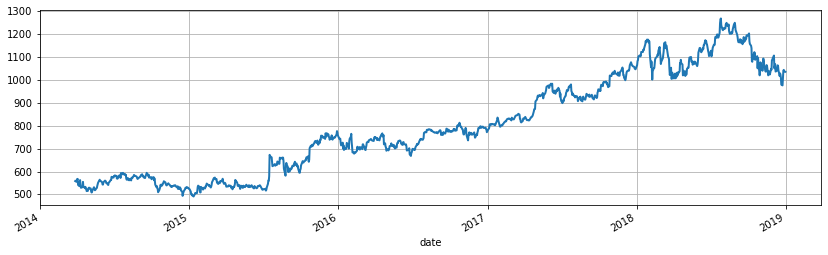

In [6]:
fig = df['Close'].plot()

#### 평가지표 정의 : MAPE

In [7]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true+ 1e-4))) * 100


def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**0.5

### 데이터 decomposition

C:\Users\jasmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


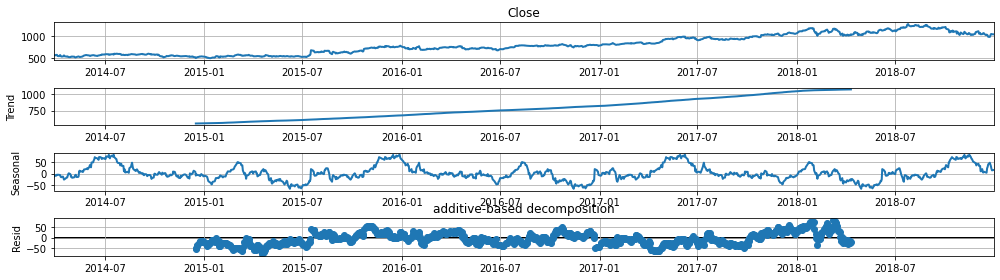

In [8]:
decomposition = sm.tsa.seasonal_decompose(df['Close'], model = 'additive', period = 365)
fig = decomposition.plot()
plt.title('additive-based decomposition')
fig.show()

C:\Users\jasmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


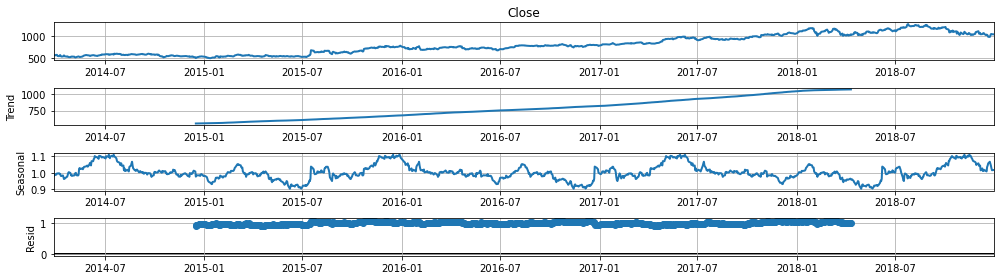

In [9]:
decomposition = sm.tsa.seasonal_decompose(df['Close'], model = 'multiplicative', period = 365)
fig = decomposition.plot()

fig.show()

#### 잔차의 독립성 검정: durbin-watson test

* 독립성 가정에 위배됨 - 잔차 간 종속성 존재

In [10]:
result = dw(df['Close'])
print('result of durbin-watson:', result)
print('sample size:', len(df))

result of durbin-watson: 0.00021653538360569673
sample size: 1200


### 데이터의 정상성 확인

#### graphical method: ACF, PACF 시각화
* ACF 가 서서히 감소하는 것을 통해 비정상성 데이터임을 확인할 수 있음.

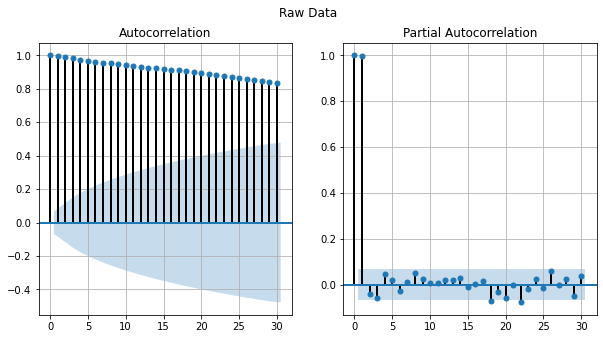

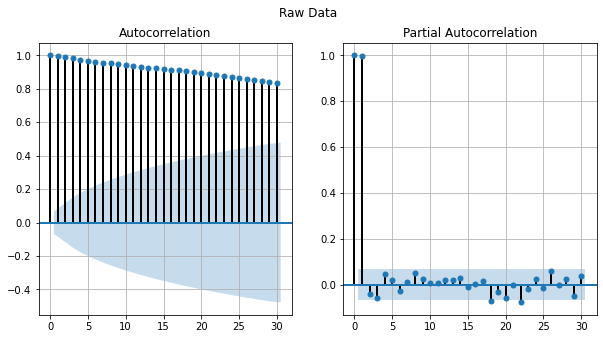

In [11]:
train_data, test_data = train_test_split(df['Close'], test_size = 0.3, shuffle = False)
fig, ax = plt.subplots(1,2,figsize = (10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(),ax = ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(),ax = ax[1])

#### statistical method: dickey-fuller test

In [12]:
result = adfuller(df['Close'], regresults = True)
print('ADF Statistics: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistics: -0.8348156511555691
p-value: 0.8086807515989319


#### [시각화]statistical method: dickey-fuller test

In [13]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(10, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

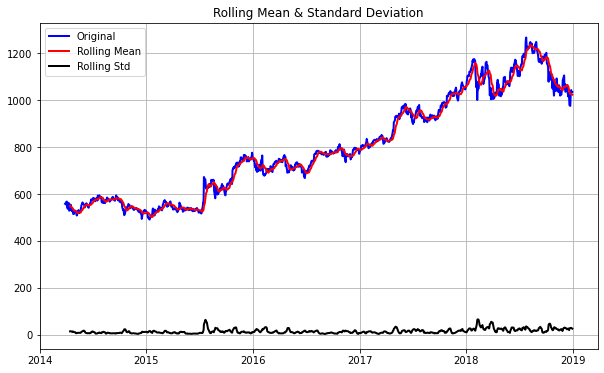

<Results of Dickey-Fuller Test>
Test Statistic                   -0.834816
p-value                           0.808681
#Lags Used                       11.000000
Number of Observations Used    1188.000000
Critical Value (1%)              -3.435866
Critical Value (5%)              -2.863976
Critical Value (10%)             -2.568067
dtype: float64


In [14]:
test_stationarity(df['Close'])

### Manual Search : p,d,q

In [15]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(train_data.values, order=(0,1,0))

#trend : constant를 가지고 있는지, c - constant / nc - no constant
#disp : 수렴 정보를 나타냄
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

forecast_data = model_fit.forecast(steps=360)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  839
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3072.375
Method:                           css   S.D. of innovations              9.422
Date:                Fri, 06 Nov 2020   AIC                           6148.749
Time:                        17:51:04   BIC                           6158.214
Sample:                             1   HQIC                          6152.377
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4641      0.325      1.427      0.154      -0.173       1.102


In [16]:
len(forecast_data[0])

360

In [17]:
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

train_data['pred']=0
test_data['pred'] = forecast_data[0]
total_manual = pd.concat([train_data, test_data])
fore = pd.DataFrame(forecast_data[0])
total_manual = total_manual.reset_index()

#total_manual['month'] = pd.to_datetime(total_manual['month'])
#total_manual = total_manual.set_index('month')

total_manual['date'] = pd.to_datetime(total_manual['date'])
total_manual = total_manual.set_index('date')

r2 = r2_score(test_data['Close'], total_manual['pred'][len(train_data):])
mape = MAPE(test_data['Close'], total_manual['pred'][len(train_data):])
rmse = RMSE(test_data['Close'], total_manual['pred'][len(train_data):])
print(r2)
print(mape)
print(rmse)

0.1541274379109009
5.856719766990913
80.80457912531054


Text(0.5, 1.0, 'ARIMA (0,1,0) , Prediction Results (MAPE: 6) (AIC: 375.848)) (RMSE: 81)')

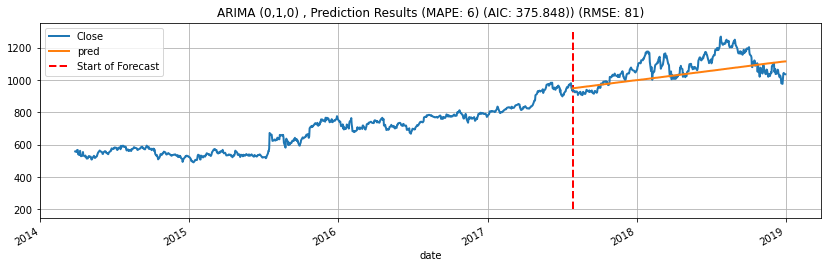

In [18]:
total_manual['Close'].plot()
plt.vlines(total_manual.index[len(train_data)+1], 200, 1300, linestyle = '--', color = 'r', label = 'Start of Forecast')
total_manual['pred'][len(train_data)+1:].plot()
plt.legend()
plt.title('ARIMA (0,1,0) , Prediction Results (MAPE: {}) (AIC: {})) (RMSE: {})'.format(round(mape), 375.848, round(rmse)))

### [방법1] 비정상성 데이터의 변환: 1차 차분

In [19]:
train_data, test_data = train_test_split(df['Close'], test_size = 0.3, shuffle = False)
from pmdarima.arima.utils import ndiffs
## Adf Test
ndiffs(train_data.values, test='adf')

1

* 1차 차분 후, ACF, PACF plot 을 통해 정상성 데이터로 변환되었는지 확인
* 통계적 방법으로 검증하였을 때, p-value = 0.00 < 0.05 이므로 정상성 데이터로 변환 되었음을 확인

In [20]:
diff_train_data = train_data.copy()
diff_train_data = diff_train_data.diff()
diff_train_data = diff_train_data.dropna()

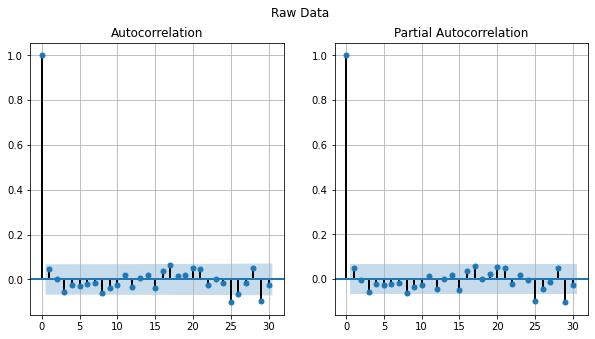

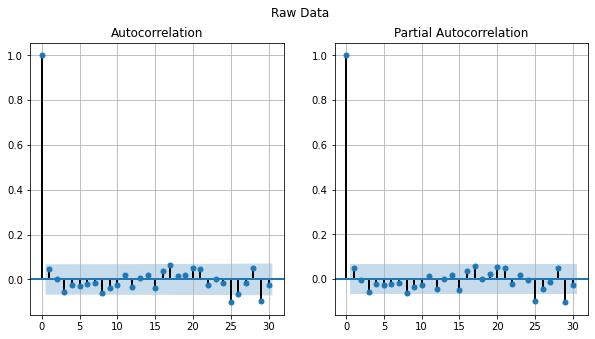

In [21]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags = 30, ax = ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags = 30, ax = ax[1])

In [22]:
result = adfuller(diff_train_data)
print('ADF Statistics: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistics: -27.568872631314054
p-value: 0.0


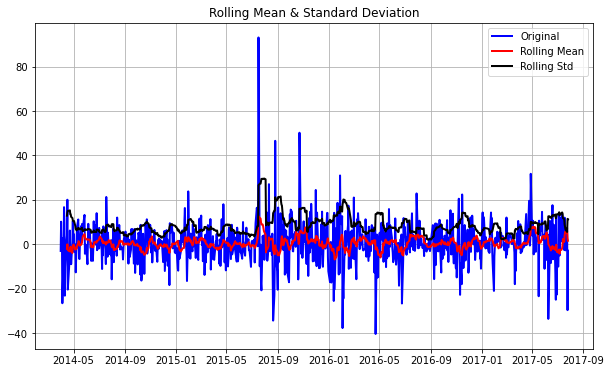

<Results of Dickey-Fuller Test>
Test Statistic                 -27.568873
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    838.000000
Critical Value (1%)             -3.438177
Critical Value (5%)             -2.864995
Critical Value (10%)            -2.568610
dtype: float64


In [23]:
test_stationarity(diff_train_data)

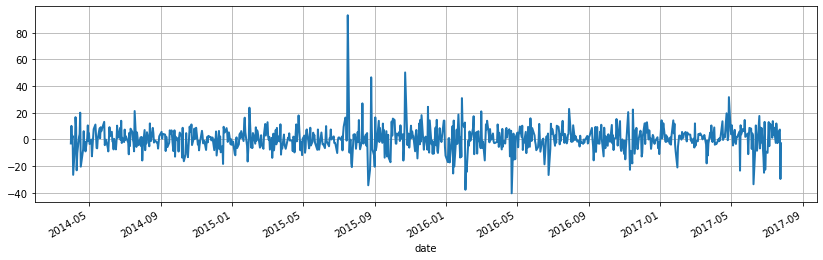

In [24]:
diff_train_data.plot()

In [25]:
diff_train_data = pd.DataFrame(diff_train_data)

#### manual search

In [26]:
train_data, test_data = train_test_split(df['Close'], test_size = 0.3, shuffle = False)

In [27]:
train_data = pd.DataFrame(train_data)

In [28]:
train_data = train_data.reset_index()
train_data['date'] = pd.to_datetime(train_data['date'])
#train_data['month'] = pd.to_datetime(train_data['month'])

In [29]:
train_data = train_data.set_index('date')
#train_data = train_data.set_index('month')

In [30]:
### 그냥 ARIMA 써보기 : ARIMA(0,1,0)
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(0,1,0))
model_fit = model.fit(trend='c',full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  839
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3072.375
Method:                           css   S.D. of innovations              9.422
Date:                Fri, 06 Nov 2020   AIC                           6148.749
Time:                        17:51:06   BIC                           6158.214
Sample:                             1   HQIC                          6152.377
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4641      0.325      1.427      0.154      -0.173       1.102


C:\Users\jasmi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jasmi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [31]:
forecast_data = model_fit.forecast(steps=360)

In [32]:
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

train_data['pred']=0
test_data['pred'] = forecast_data[0]
total_manual = pd.concat([train_data, test_data])
fore = pd.DataFrame(forecast_data[0])
total_manual = total_manual.reset_index()

#total_manual['month'] = pd.to_datetime(total_manual['month'])
#total_manual = total_manual.set_index('month')

total_manual['date'] = pd.to_datetime(total_manual['date'])
total_manual = total_manual.set_index('date')

In [33]:
r2 = r2_score(test_data['Close'], total_manual['pred'][len(train_data):])
mape = MAPE(test_data['Close'], total_manual['pred'][len(train_data):])
rmse = RMSE(test_data['Close'], total_manual['pred'][len(train_data):])
print(r2)
print(mape)
print(rmse)

0.1541274379109009
5.856719766990913
80.80457912531054


Text(0.5, 1.0, 'ARIMA (0,1,0) , Prediction Results (MAPE: 6) (AIC: 6159.733) (RMSE: 81))')

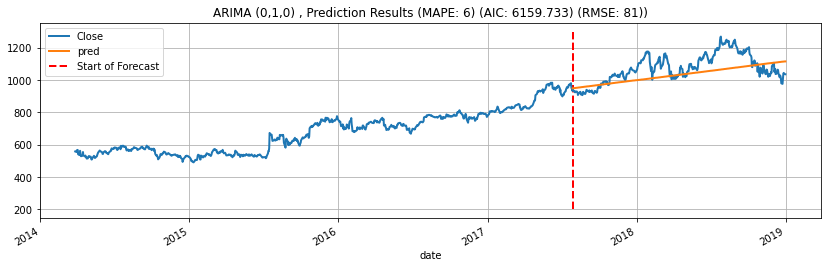

In [34]:
total_manual['Close'].plot()
plt.vlines(total_manual.index[len(train_data)+1], 200, 1300, linestyle = '--', color = 'r', label = 'Start of Forecast')
total_manual['pred'][len(train_data)+1:].plot()
plt.legend()
plt.title('ARIMA (0,1,0) , Prediction Results (MAPE: {}) (AIC: {}) (RMSE: {}))'.format(round(mape), 6159.733, round(rmse)))

#### 잔차 ACF, PACF 확인

NormaltestResult(statistic=293.31770620211927, pvalue=2.0270729390345608e-64)


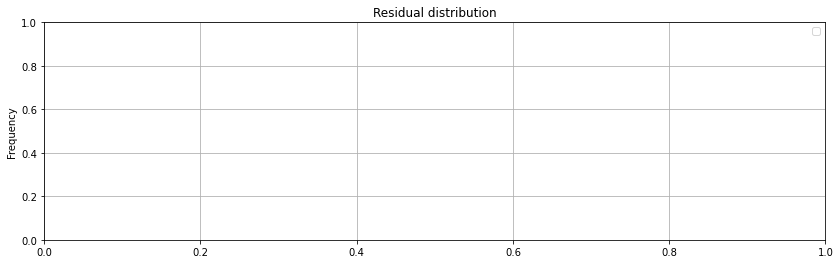

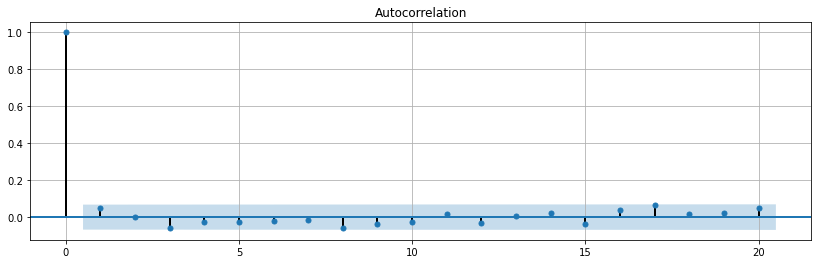

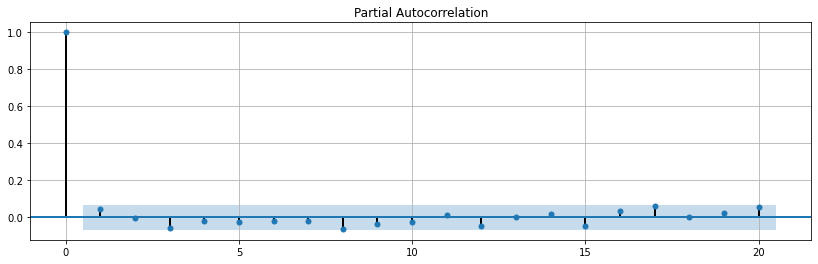

In [35]:
from scipy import stats
from scipy.stats import normaltest
import seaborn as sns

resid = model_fit.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

#fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = sm.graphics.tsa.plot_acf(model_fit.resid, lags=20)
fig = sm.graphics.tsa.plot_pacf(model_fit.resid, lags=20)

#### auto_arima 적용

In [36]:
train_data, test_data = train_test_split(df['Close'], test_size = 0.3, shuffle = False)

In [37]:
### auto arima 로 찾은 parameter 가 적합한지 확인
auto_arima_model = auto_arima(train_data, start_p =1, start_q =1,
                             max_p = 12, max_q =12, seasonal = False,
                             d=1,
                             trace = True, 
                             error_action = 'ignore',
                             suppress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6150.848, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6148.749, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6148.849, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6148.856, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6148.782, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.806 seconds


In [38]:
auto_arima_model = auto_arima_model.fit(train_data)

In [39]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int = True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)

test_data = pd.DataFrame(test_data)

test_data['pred'] = prediction[0]
r2 = r2_score(test_data['Close'], test_data['pred'])
mape = MAPE(test_data['Close'], test_data['pred'])
rmse = RMSE(test_data['Close'], test_data['pred'])
print(r2)
print(mape)
print(rmse)

train_data = pd.DataFrame(train_data)
train_data['pred'] = 0

total = pd.concat([train_data,test_data])

0.1541274379109009
5.856719766990913
80.80457912531054


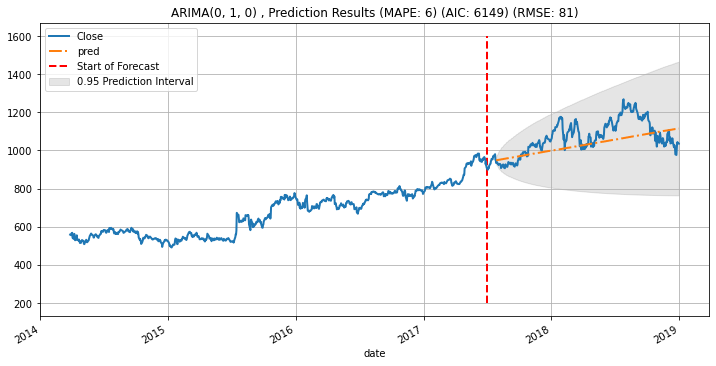

In [40]:
fig, ax = plt.subplots(figsize = (12,6))
total['Close'].plot(ax = ax)
ax.vlines('2017-07-01', 200, 1600, linestyle = '--', color = 'r', label = 'Start of Forecast')
ax = test_data['pred'].plot(linestyle = '-.')
ax.fill_between(predict_index, predicted_ub, predicted_lb, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')
ax.legend(loc = 'upper left')
plt.title('ARIMA{} , Prediction Results (MAPE: {}) (AIC: {}) (RMSE: {})'.format(auto_arima_model.order, round(mape), round(auto_arima_model.aic()), round(rmse)))
plt.show()

NormaltestResult(statistic=1964.288212511495, pvalue=0.0)


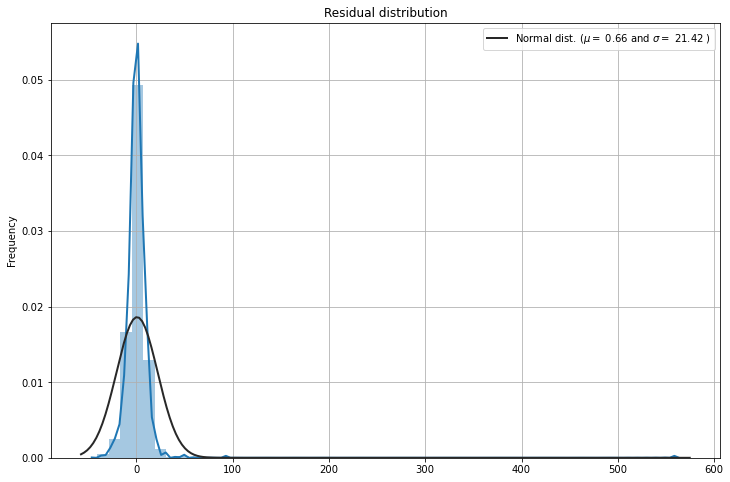

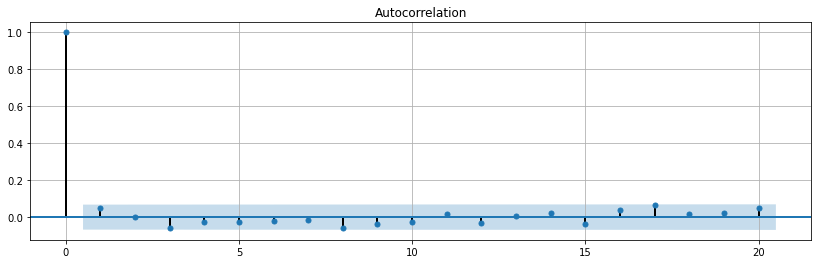

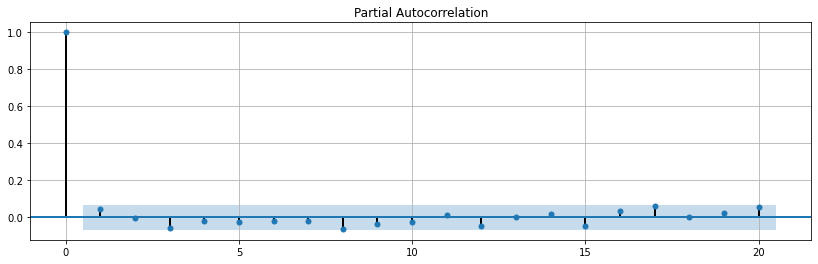

In [41]:
resid = auto_arima_model.resid()
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

(mu, sigma) = stats.norm.fit(resid)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

fig = sm.graphics.tsa.plot_acf(model_fit.resid, lags=20)
fig = sm.graphics.tsa.plot_pacf(model_fit.resid, lags=20)

#### Seasonal ARIMA 적용 (auto_arima)

In [42]:
train_data, test_data = train_test_split(df['Close'], test_size = 0.3, shuffle = False)

In [43]:
for i in range(1,10,3):
    auto_sarima_model = auto_arima(train_data, start_p =1, start_q =1,
                                 max_p = 3, max_q =3, m = i, seasonal = True,
                                 d=1, D=1,
                                 max_P = 2, max_Q =2,
                                 trace = True, 
                                 error_action = 'ignore',
                                 suppress_warnings = True,
                                stepwise = True, with_intercept = True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6150.848, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6148.749, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6148.849, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6148.856, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6148.782, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.836 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=6717.666, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[4] intercept   : AIC=6495.329, Time=0.50 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=6715.672, Time=0.04 sec
 ARIMA(1,1,0)(0,1,0)[4] intercept   : AIC=6712.909, Time=0.21 sec
 ARIMA(1,1,0)(2,1,0)[4] intercept   : AIC=6394.515, Time=0.63 sec
 ARIMA(1,1,0)(2,1,1)[4] intercept   : AIC=inf, Time=1.4

In [44]:
auto_sarima_model = auto_arima(train_data, start_p =1, start_q =1,
                             max_p = 2, max_q =2, m=1, seasonal = True,
                             d=1, D=1,max_P = 1, max_Q = 1,
                             trace = True, 
                             error_action = 'ignore',
                             suppress_warnings = True, with_intercept = True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6150.848, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6148.749, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6148.849, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6148.856, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6148.782, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.748 seconds


In [45]:
auto_sarima_model.aic()

6148.74912515773

In [46]:
auto_sarima_model = auto_sarima_model.fit(train_data)

prediction = auto_sarima_model.predict(len(test_data), return_conf_int = True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

test_data['pred'] = prediction[0]
r2 = r2_score(test_data['Close'], test_data['pred'])
print(r2)
mape = MAPE(test_data['Close'], test_data['pred'])
rmse = RMSE(test_data['Close'], test_data['pred'])
print(mape)
print(rmse)

train_data['pred'] = 0
total = pd.concat([train_data,test_data])

0.1541274379109009
5.856719766990913
80.80457912531054


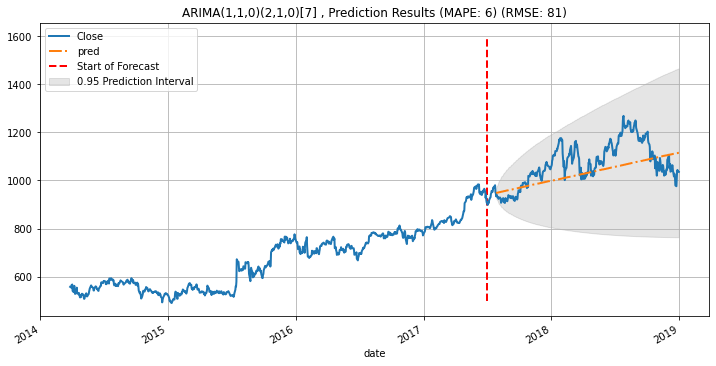

In [47]:
fig, ax = plt.subplots(figsize = (12,6))
total['Close'].plot(ax = ax)
ax.vlines('2017-07-01', 500, 1600, linestyle = '--', color = 'r', label = 'Start of Forecast')
ax = test_data['pred'].plot(linestyle = '-.')
ax.fill_between(predict_index, predicted_ub, predicted_lb, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')
ax.legend(loc = 'upper left')
plt.title('ARIMA{} , Prediction Results (MAPE: {}) (RMSE: {})'.format('(1,1,0)(2,1,0)[7]', round(mape), round(rmse)))
plt.show()

NormaltestResult(statistic=1964.288212511495, pvalue=0.0)


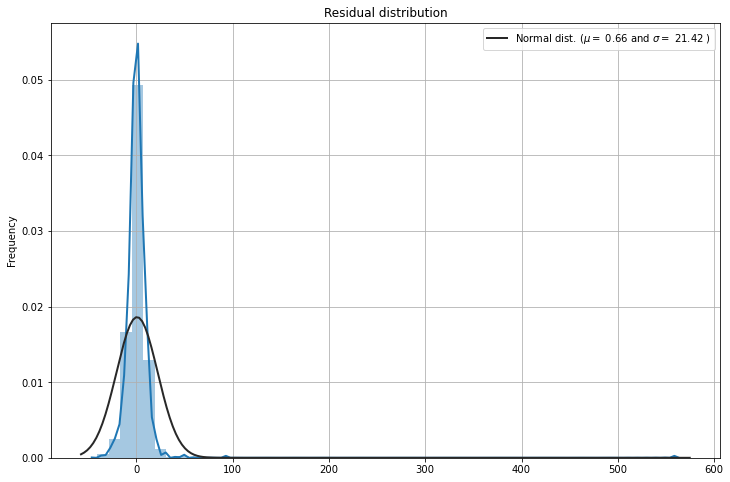

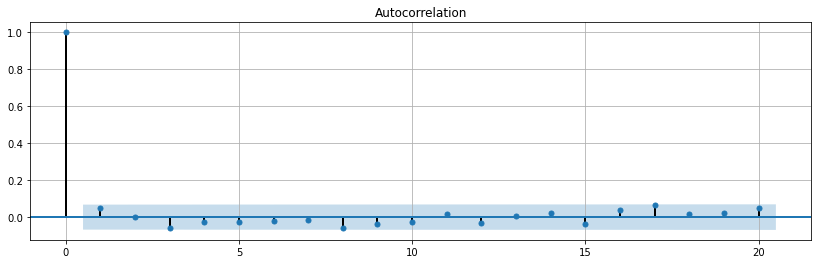

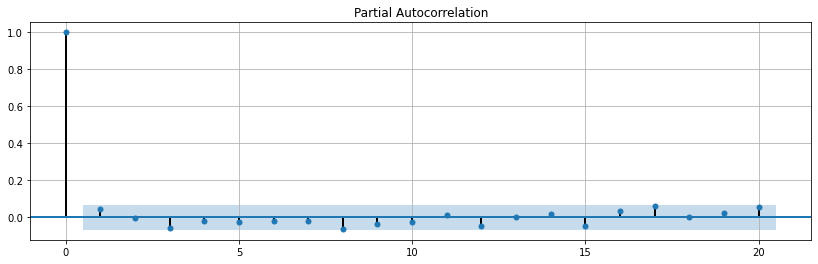

In [48]:
resid = auto_sarima_model.resid()
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

(mu, sigma) = stats.norm.fit(resid)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

fig = sm.graphics.tsa.plot_acf(model_fit.resid, lags=20)
fig = sm.graphics.tsa.plot_pacf(model_fit.resid, lags=20)

### [방법2] 비정상성 데이터: log scale 변환

In [49]:
train_data, test_data = train_test_split(df['Close'], test_size = 0.3, shuffle = False)

In [50]:
train_data = pd.DataFrame(train_data)
diff_train_data = np.log1p(np.abs(diff_train_data))

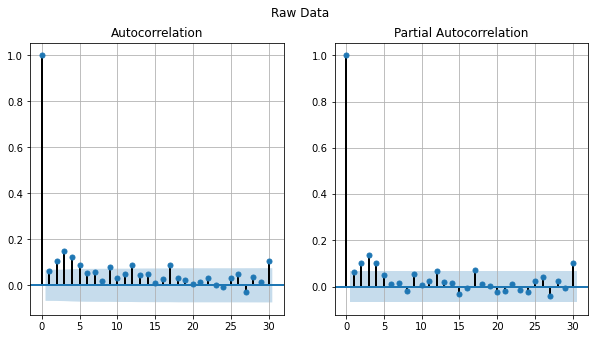

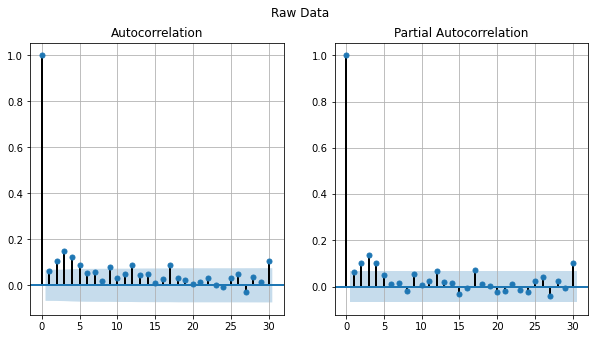

In [51]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags = 30, ax = ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags = 30, ax = ax[1])

In [52]:
result = adfuller(diff_train_data)
print('ADF Statistics: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistics: -9.569854063885819
p-value: 2.3038398889720764e-16


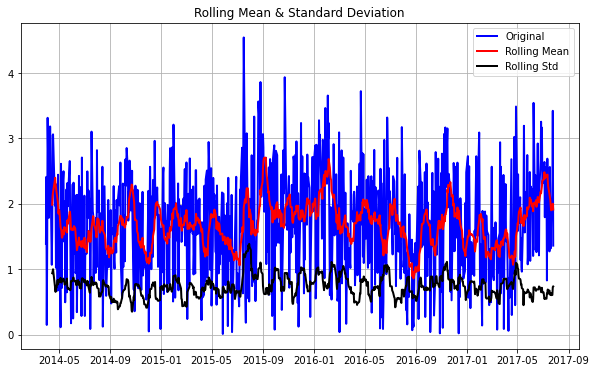

<Results of Dickey-Fuller Test>
Test Statistic                -9.569854e+00
p-value                        2.303840e-16
#Lags Used                     4.000000e+00
Number of Observations Used    8.340000e+02
Critical Value (1%)           -3.438215e+00
Critical Value (5%)           -2.865012e+00
Critical Value (10%)          -2.568619e+00
dtype: float64


In [53]:
test_stationarity(diff_train_data)

#### manual search

In [54]:
### 그냥 ARIMA 써보기 : ARIMA(0,1,0)
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(3,1,0))
model_fit = model.fit(trend='c',full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  839
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -3069.994
Method:                       css-mle   S.D. of innovations              9.395
Date:                Fri, 06 Nov 2020   AIC                           6149.987
Time:                        17:51:51   BIC                           6173.648
Sample:                             1   HQIC                          6159.056
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4651      0.321      1.448      0.148      -0.164       1.094
ar.L1.D.Close     0.0475      0.034      1.380      0.168      -0.020       0.115
ar.L2.D.Close     0.0009      0.035     

C:\Users\jasmi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jasmi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [55]:
forecast_data = model_fit.forecast(steps=360)

In [56]:
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

train_data['pred']=0
test_data['pred'] = forecast_data[0]
total_manual = pd.concat([train_data, test_data])
fore = pd.DataFrame(forecast_data[0])
total_manual = total_manual.reset_index()

#total_manual['month'] = pd.to_datetime(total_manual['month'])
#total_manual = total_manual.set_index('month')

total_manual['date'] = pd.to_datetime(total_manual['date'])
total_manual = total_manual.set_index('date')

In [57]:
r2 = r2_score(test_data['Close'], total_manual['pred'][len(train_data):])
mape = MAPE(test_data['Close'], total_manual['pred'][len(train_data):])
rmse = RMSE(test_data['Close'], total_manual['pred'][len(train_data):])
print(r2)
print(mape)
print(rmse)

0.17040516867443545
5.816669529526068
80.02331208889804


Text(0.5, 1.0, 'ARIMA (0,1,0) , Prediction Results (MAPE: 6) (AIC: 6159.733) (RMSE: 80))')

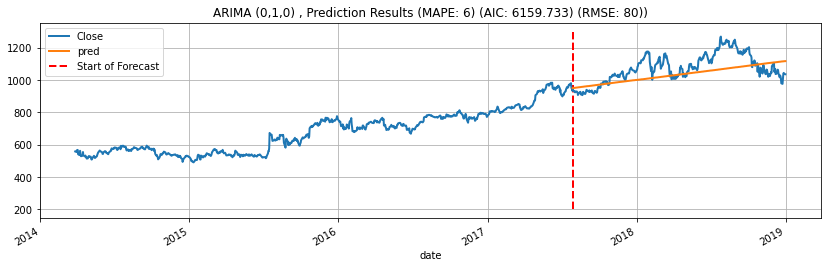

In [58]:
total_manual['Close'].plot()
plt.vlines(total_manual.index[len(train_data)+1], 200, 1300, linestyle = '--', color = 'r', label = 'Start of Forecast')
total_manual['pred'][len(train_data)+1:].plot()
plt.legend()
plt.title('ARIMA (0,1,0) , Prediction Results (MAPE: {}) (AIC: {}) (RMSE: {}))'.format((round(mape)), 6159.733, round(rmse)))

#### 잔차 ACF, PACF

NormaltestResult(statistic=290.3472518672503, pvalue=8.951490171120318e-64)


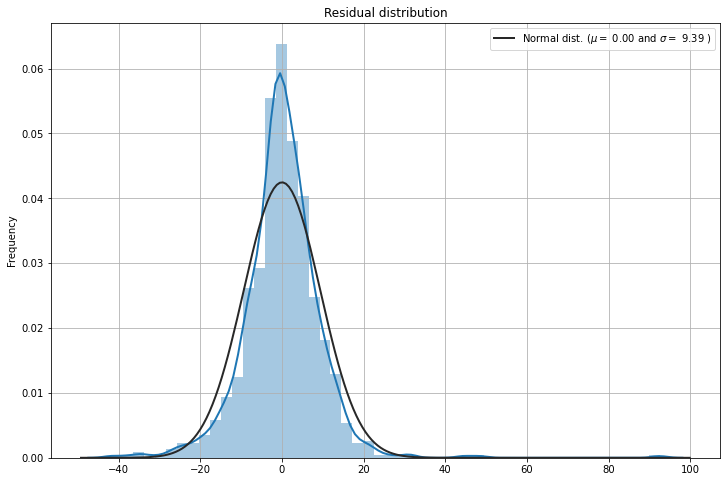

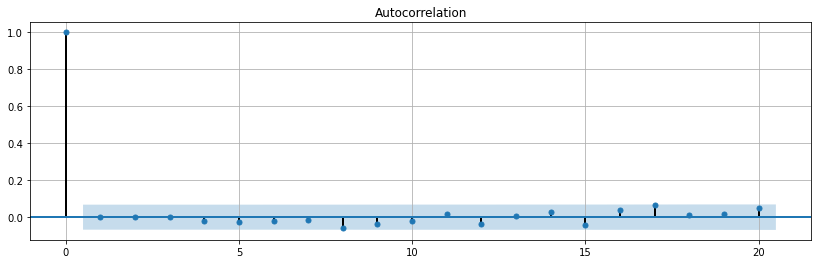

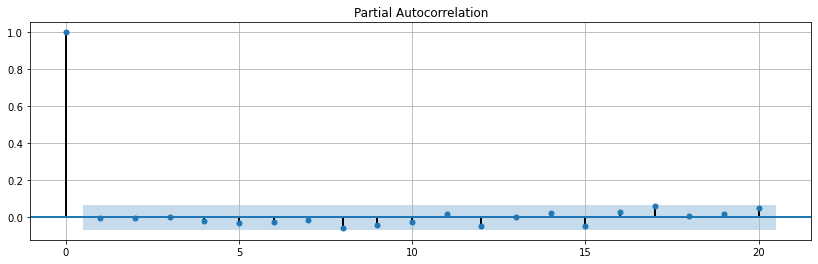

In [59]:
resid = model_fit.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

(mu, sigma) = stats.norm.fit(resid)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

fig = sm.graphics.tsa.plot_acf(model_fit.resid, lags=20)
fig = sm.graphics.tsa.plot_pacf(model_fit.resid, lags=20)

#### auto_arima 적용

In [60]:
train_data, test_data = train_test_split(df['Close'], test_size = 0.3, shuffle = False)

In [61]:
### auto arima 로 찾은 parameter 가 적합한지 확인
auto_arima_model = auto_arima(train_data, start_p =1, start_q =1,
                             max_p = 12, max_q =12, seasonal = False,
                             d=1,
                             trace = True, 
                             error_action = 'ignore',
                             suppress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6150.848, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6148.749, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6148.849, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6148.856, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6148.782, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.779 seconds


In [62]:
auto_arima_model = auto_arima_model.fit(train_data)

In [63]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int = True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)

test_data = pd.DataFrame(test_data)

test_data['pred'] = prediction[0]
r2 = r2_score(test_data['Close'], test_data['pred'])
mape = MAPE(test_data['Close'], test_data['pred'])
rmse = RMSE(test_data['Close'], test_data['pred'])
print(r2)
print(mape)
print(rmse)

train_data = pd.DataFrame(train_data)
train_data['pred'] = 0

total = pd.concat([train_data,test_data])

0.1541274379109009
5.856719766990913
80.80457912531054


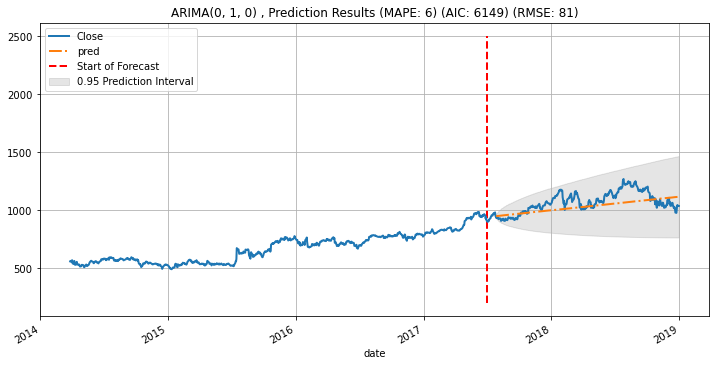

In [64]:
fig, ax = plt.subplots(figsize = (12,6))
total['Close'].plot(ax = ax)
ax.vlines('2017-07-01', 200, 2500, linestyle = '--', color = 'r', label = 'Start of Forecast')
ax = test_data['pred'].plot(linestyle = '-.')
ax.fill_between(predict_index, predicted_ub, predicted_lb, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')
ax.legend(loc = 'upper left')
plt.title('ARIMA{} , Prediction Results (MAPE: {}) (AIC: {}) (RMSE: {})'.format(auto_arima_model.order, round(mape), round(auto_arima_model.aic()), round(rmse)))
plt.show()

NormaltestResult(statistic=1964.288212511495, pvalue=0.0)


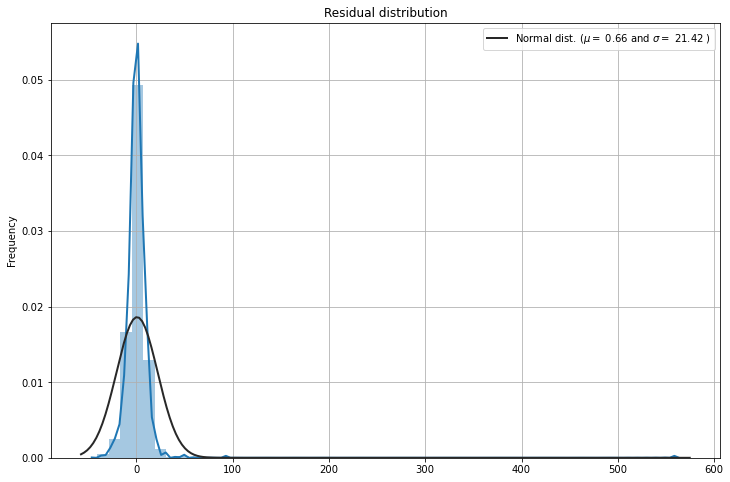

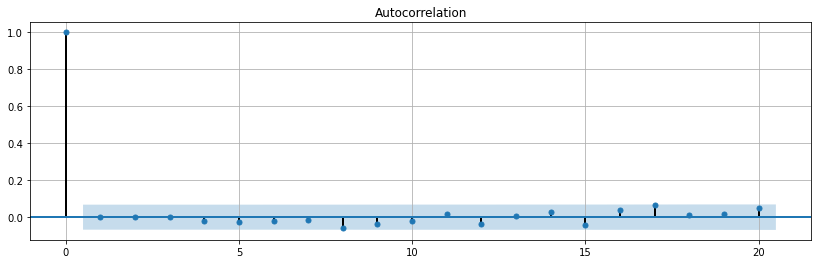

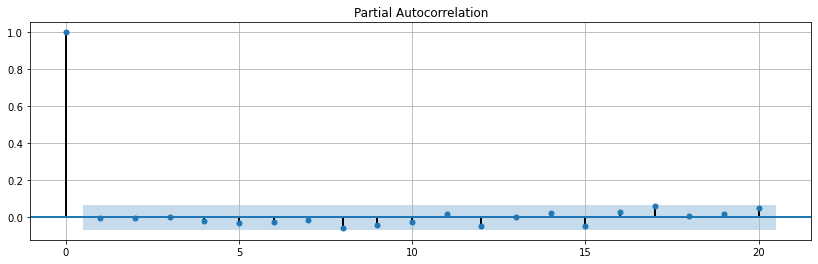

In [65]:
resid = auto_arima_model.resid()
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

(mu, sigma) = stats.norm.fit(resid)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

fig = sm.graphics.tsa.plot_acf(model_fit.resid, lags=20)
fig = sm.graphics.tsa.plot_pacf(model_fit.resid, lags=20)

In [ ]:
####